Epoch [10/100], Loss: 0.0170
Epoch [20/100], Loss: 0.0002
Epoch [30/100], Loss: 0.0001
Epoch [40/100], Loss: 0.0001
Epoch [50/100], Loss: 0.0001
Epoch [60/100], Loss: 0.0000
Epoch [70/100], Loss: 0.0000
Epoch [80/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000


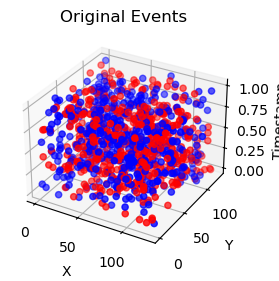

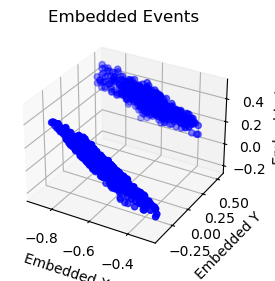

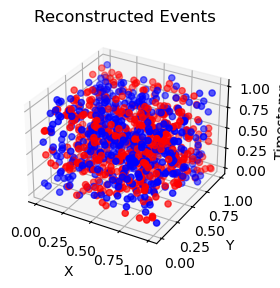

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate synthetic events
def generate_synthetic_events(num_events, sensor_width, sensor_height):
    timestamps = np.random.uniform(0, 1, num_events)
    x_coords = np.random.randint(0, sensor_width, num_events)
    y_coords = np.random.randint(0, sensor_height, num_events)
    polarities = np.random.choice([-1, 1], num_events)
    events = np.vstack((timestamps, x_coords, y_coords, polarities)).T
    return events

# Normalize the events
def normalize_events(events, sensor_width, sensor_height):
    events[:, 0] = (events[:, 0] - events[:, 0].min()) / (events[:, 0].max() - events[:, 0].min())
    events[:, 1] = events[:, 1] / sensor_width
    events[:, 2] = events[:, 2] / sensor_height
    return events

# Define the autoencoder
class EventAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedded_dim):
        super(EventAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embedded_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(embedded_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def embed(self, x):
        return self.encoder(x)

# Parameters
num_events = 1000
sensor_width = 128
sensor_height = 128
hidden_dim = 64
embedded_dim = 64  # For 3D visualization of embedded space
batch_size = 128
num_epochs = 100
learning_rate = 0.001

# Generate synthetic events
events = generate_synthetic_events(num_events, sensor_width, sensor_height)
normalized_events = normalize_events(events.copy(), sensor_width, sensor_height)
events_tensor = torch.tensor(normalized_events, dtype=torch.float32)

# Initialize the autoencoder
input_dim = 4
model = EventAutoencoder(input_dim, hidden_dim, embedded_dim)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the autoencoder
model.train()
for epoch in range(num_epochs):
    for i in range(0, len(events_tensor), batch_size):
        batch = events_tensor[i:i+batch_size]
        output = model(batch)
        loss = criterion(output, batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


# Get the embeddings and reconstructions
model.eval()
with torch.no_grad():
    embeddings = model.embed(events_tensor).numpy()  # Get the embeddings
    reconstructed_events = model(events_tensor).numpy()  # Get the reconstructions

# Visualization
def visualize_events(events, title, subplot, is_embedded=False):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(subplot, projection='3d')
    if is_embedded:
        x, y, z = events[:, 0], events[:, 1], events[:, 2]
        ax.scatter(x, y, z, c='b', marker='o')
        ax.set_xlabel('Embedded X')
        ax.set_ylabel('Embedded Y')
        ax.set_zlabel('Embedded Z')
    else:
        t, x, y, p = events[:, 0], events[:, 1], events[:, 2], events[:, 3]
        colors = ['r' if polarity > 0 else 'b' for polarity in p]
        ax.scatter(x, y, t, c=colors, marker='o')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Timestamp')
    ax.set_title(title)
    plt.show()

# Visualize original events
visualize_events(events, 'Original Events', 131, is_embedded=False)

# Visualize embedded events
visualize_events(embeddings, 'Embedded Events', 132, is_embedded=True)

# Visualize reconstructed events
visualize_events(reconstructed_events, 'Reconstructed Events', 133, is_embedded=False)


In [2]:
print(embeddings.shape)

(1000, 64)


In [3]:
print(events.shape)

(1000, 4)
